<a href="https://colab.research.google.com/github/devilubis/thesis/blob/dev/thesis_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
# import libraries
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [150]:
# authenticate to GCS account
from google.colab import auth
auth.authenticate_user()

In [151]:
# download data from GCS
!gsutil cp 'gs://tesis_devi/twitter_4000.csv' ./

Copying gs://tesis_devi/twitter_4000.csv...
/ [1 files][458.4 KiB/458.4 KiB]                                                
Operation completed over 1 objects/458.4 KiB.                                    


In [152]:
# read and shuffle data
data = pd.read_csv('twitter_4000.csv')
data = shuffle(data, random_state=21)

data.head(3)

,tweet,tag
3132,euh ouai le rapport avec camus si vous navez ...,france
2299,hah tadi kamu post di holy kah kok aku gak nyadar,indonesia
224,be a better you for you,english


In [153]:
# create label
labels = [labels.split(',') for labels in data['tag'].values]
encoder = MultiLabelBinarizer()
encoded_label = encoder.fit_transform(labels)
num_label = len(encoded_label[0])

print(data['tweet'].values[0])

print(encoder.classes_)
print(encoded_label[0])

euh ouai le rapport avec camus  si vous navez pas compris la rfrence foucault je peux vous expliquer donc nous sommes daccord  facultuellement il y a changement de population culturelle  vous trouvez a bien  moi dramatique  cest l notre diffrence
['english' 'france' 'germany' 'indonesia']
[0 1 0 0]


In [154]:
# split data

train_size = int(len(data) * .8)
train_label = encoded_label[:train_size]
test_label = encoded_label[train_size:]

In [155]:
# tokenizer class
# keras for building BoW model
%%writefile preprocess.py

from tensorflow.keras.preprocessing import text

class TextPreprocessor(object):
  def __init__(self, vocab_size):
    self.vocab_size = vocab_size
    self.tokenizer = None

  def create_tokenizer(self, text_list):
    tokenizer = text.Tokenizer(num_words=self.vocab_size)
    tokenizer.fit_on_texts(text_list)
    self._tokenizer = tokenizer

  def transform_text(self, text_list):
    text_matrix = self._tokenizer.texts_to_matrix(text_list)
    return text_matrix

Overwriting preprocess.py


In [156]:
# implementing Bow

from preprocess import TextPreprocessor

train_tweet = data['tweet'].values[:train_size]
test_tweet = data['tweet'].values[train_size:]

VOCAB_SIZE = 200

processor = TextPreprocessor(VOCAB_SIZE)
processor.create_tokenizer(train_tweet)

body_train = processor.transform_text(train_tweet)
body_test = processor.transform_text(test_tweet)

print(train_tweet[0])
print(body_train[0])


euh ouai le rapport avec camus  si vous navez pas compris la rfrence foucault je peux vous expliquer donc nous sommes daccord  facultuellement il y a changement de population culturelle  vous trouvez a bien  moi dramatique  cest l notre diffrence
[0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [157]:
# create model
def create_model(vocab_size, num_tags):
  model = Sequential() # MLP
  model.add(Dense(50, input_shape=(vocab_size,), activation='relu')) # first layer / input
  model.add(Dense(25, activation='relu')) # hidden layer
  model.add(Dense(num_label, activation='sigmoid')) # output layer

  # set up loss function, weight update method, and value to show when running model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = create_model(VOCAB_SIZE, num_label)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                10050     
                                                                 
 dense_7 (Dense)             (None, 25)                1275      
                                                                 
 dense_8 (Dense)             (None, 4)                 104       
                                                                 
Total params: 11,429
Trainable params: 11,429
Non-trainable params: 0
_________________________________________________________________


In [158]:
# train model
history = model.fit(body_train, train_label, epochs=3, batch_size=128, validation_split=0.1)

Train on 2880 samples, validate on 320 samples
Epoch 1/3
2880/2880 [==============================] - 0s 41us/sample - loss: 0.6170 - acc: 0.7398 - val_loss: 0.5450 - val_acc: 0.7969
Epoch 2/3
2880/2880 [==============================] - 0s 16us/sample - loss: 0.4672 - acc: 0.8157 - val_loss: 0.3813 - val_acc: 0.8477
Epoch 3/3
2880/2880 [==============================] - 0s 14us/sample - loss: 0.3004 - acc: 0.9198 - val_loss: 0.2153 - val_acc: 0.9711


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [159]:
# evaluate model
prediction = model.evaluate(body_test, test_label, batch_size=128)
print(prediction)

[0.2239321994781494, 0.9684375]


In [160]:
# save model
model.save('thesis_twitter_model.h5')

In [163]:
import shap

explainer = shap.DeepExplainer(model, body_train[:200])
shap_vals = explainer.shap_values(body_test[:25])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [164]:
words = processor._tokenizer.word_index

word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup
print(word_lookup[:100])

['', 'de', 'die', 'a', 'the', 'und', 'to', 'in', 'and', 'ich', 'et', 'nicht', 'la', 'aku', 'you', 'das', 'le', 'der', 'i', 'my', 'this', 'je', 'of', 'les', 'ist', 'ini', 'dia', 'is', 'pas', 'on', 'that', 'que', 'des', 'en', 'es', 'itu', 'for', 'kamu', 'un', 'so', 'yang', 'moi', 'cette', 'me', 'di', 'du', 'auch', 'zu', 'elle', 'pour', 'dan', 'bien', 'was', 'cest', 'den', 'est', 'im', 'it', 'qui', 'ein', 'fr', 'vous', 'wie', 'auf', 'une', 'yg', 'ce', 'mit', 'aber', 'sie', 'dies', 'an', 'ya', 'dass', 'von', 'ada', 'are', 'with', 'il', 'will', 'dans', 'have', 'eine', 'be', 'ga', 'your', 'hat', 'like', 'avec', 'at', 'au', 'wenn', 'amp', 'jai', 'sich', 'ne', 'sur', 'mais', 'man', 'all']


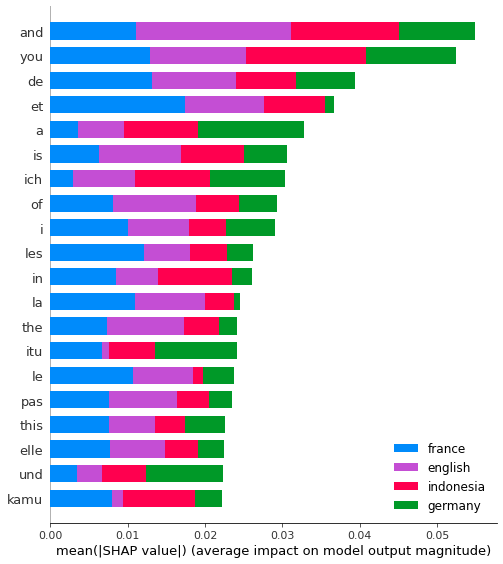

In [166]:
# plot
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=encoder.classes_)